# WINE RESEARCH, CLUSTERING AND RECOMMENDATION SYSTEM
Data parsed from the site [vivino.com](https://www.vivino.com/IT/en/)

June 2022
___

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

import ast
import re

from scipy.stats import spearmanr, ttest_ind, f_oneway, zscore, boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import prince
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# keeping experiments reproducible
RANDOM_SEED = 42 
# settings to display all columns
pd.set_option('display.max_columns', None)
# set the graphs options
sns.set_palette(sns.color_palette('inferno'))
sns.set(rc={'figure.figsize': (12, 8), 'legend.fontsize': 14, 
            'legend.title_fontsize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12,
            'axes.titlesize': 20,  'axes.labelsize': 14})
sns.set_style('whitegrid', {'axes.grid': False})

In [52]:
# dataframe with wine data
df = pd.read_csv('data/data.csv')
# dataframe with user wine ratings
df_user = pd.read_csv('data/df_user.csv')

# original dtaframe copy
df_copy = df.copy()

In [53]:
df.head()

Vintage_wine_id                                       Vintage_wine    Year  \
0          1122234                    Tua Rita Redigaffi Toscana 2002  2002.0   
1        152279287         Soldera Case Basse Sangiovese Toscana 2015  2015.0   
2          1419059   Biondi-Santi Brunello di Montalcino Riserva 2012  2012.0   
3          2437223                    Tua Rita Redigaffi Toscana 2000  2000.0   
4          2486162  Philippe Pacalet Charmes-Chambertin Grand Cru ...  2011.0   

   Wine_id                            Wine  Wine_type  Ratings_average  \
0    75816               Redigaffi Toscana          1              4.3   
1  2669217   Case Basse Sangiovese Toscana          1              4.8   
2    82698  Brunello di Montalcino Riserva          1              4.7   
3    75816               Redigaffi Toscana          1              4.6   
4  1133293    Charmes-Chambertin Grand Cru          1              4.0   

   Ratings_count  Price(€)  Bottle_quantity  Price_without_discount(€)  \
0            113     499.0                1                        NaN   
1             26     499.0                1                      750.0   
2             84     498.0                1                        NaN   
3             80     495.0                1                        NaN   
4             32     493.0                1                        NaN   

   Bottle_type_id Bottle_type_name  Bottle_volume  Winery_id  \
0               4           magnum           1500      11007   
1               1           bottle            750      11292   
2               1           bottle            750      11500   
3               1           bottle            750      11007   
4               1           bottle            750       4739   

             Winery  Region_id                        Region Country  \
0          Tua Rita        394                       Toscana   Italy   
1           Soldera        394                       Toscana   Italy   
2      Biondi-Santi       1796        Brunello di Montalcino   Italy   
3          Tua Rita        394                       Toscana   Italy   
4  Philippe Pacalet       2204  Charmes-Chambertin Grand Cru  France   

   Regions_count  Users_count  Wineries_count  Wines_count  \
0            554      3388686           39314       324259   
1            554      3388686           39314       324259   
2            554      3388686           39314       324259   
3            554      3388686           39314       324259   
4           1280      3962152           65154       490148   

                   Wine_style Acidity              Body  \
0                  Tuscan Red  Medium     Medium-bodied   
1                  Tuscan Red  Medium     Medium-bodied   
2            Italian Brunello    High  Very full-bodied   
3                  Tuscan Red  Medium     Medium-bodied   
4  Burgundy Côte de Nuits Red    High     Medium-bodied   

                              Wine_style_description Wine_region_name  \
0                                                NaN           Tuscan   
1                                                NaN           Tuscan   
2  From Tuscany in central Italy, Brunello enjoys...          Italian   
3                                                NaN           Tuscan   
4                                                NaN         Burgundy   

                                              Grapes  \
0  ['Cabernet Sauvignon', 'Merlot', 'Sangiovese',...   
1  ['Cabernet Sauvignon', 'Merlot', 'Sangiovese',...   
2                                     ['Sangiovese']   
3  ['Cabernet Sauvignon', 'Merlot', 'Sangiovese',...   
4                                     ['Pinot Noir']   

                                                Food  \
0  ['Beef', 'Lamb', 'Veal', 'Poultry', 'Cured Meat']   
1  ['Beef', 'Lamb', 'Veal', 'Poultry', 'Cured Meat']   
2  ['Beef', 'Lamb', 'Game (deer, venison)', 'Poul...   
3  ['Beef', 'Lamb', 'Veal', 'Poultry', 'Cured Meat']   
4  ['Beef', 'Veal', 'Gam

### Features Defination

- Vintage_wine_id - wine identification (with vintage)

- Vintage_wine - full wine name (with vintage)

- Year - wine vintage year (if Nan, non-vintage wine)

- Wine_id - wine identification (any vintage)

- Wine - wine name (any vintage)

- Wine_type - type of wine (1: red, 2: white, 3: sparkling, 4: rose)

- Ratings_average - average number of stars (max 5)

- Ratings_count - number of votes

- Price(€) - wine price (in euro)

- Bottle_quantity - available number of bottles to order

- Price_without_discount(€) - wine price without discount

- Bottle_type_id - wine bottle type identification

- Bottle_type_name - wine bottle type name

- Bottle_volume - wine bottle volume (in milliliters)

- Winery_id - winery identification

- Winery - winery name

- Region_id - wine region identification

- Region - wine region name 

- Regions_count - number of wine regions in the country

- Users_count - number of users from a particular country

- Wineries_count - number of wineries from a particular country

- Wines_count - number of wines from a particular country

- Wine_style - wine style name (takes into account the combination of color, taste, alcohol strength, etc.)

- Acidity - acidity of wine determined by the manufacturer

- Body - body of wine determined by the manufacturer

- Wine_style_description - wine style description

- Wine_region_name - marketing name of the wine region

- Grapes - list of grape varieties

- Food - wine food list

- Flavor - list of flavor notes noted by users

- Taste - taste rating on scales softness-acidity, lightness-intensity, dryness-sweetness, smoothness-tannins, gently-fizziness


# EDA

In [54]:
df.describe()

Vintage_wine_id         Year       Wine_id    Wine_type  \
count     5.235000e+03  4946.000000  5.235000e+03  5235.000000   
mean      7.474485e+07  2011.748888  1.473365e+06     1.911366   
std       7.273116e+07     7.387144  1.577414e+06     0.867059   
min       2.036000e+03  1948.000000  1.264000e+03     1.000000   
25%       2.742372e+06  2009.000000  8.269000e+04     1.000000   
50%       2.655586e+07  2014.000000  1.203712e+06     2.000000   
75%       1.549988e+08  2017.000000  1.818958e+06     3.000000   
max       1.650833e+08  2020.000000  8.282960e+06     4.000000   

       Ratings_average  Ratings_count     Price(€)  Bottle_quantity  \
count      5235.000000    5235.000000  5235.000000      5235.000000   
mean          4.150984     439.008596   107.646576         1.145368   
std           0.286274    2319.216970   106.622971         1.216400   
min           2.900000      25.000000     4.940000         1.000000   
25%           3.900000      51.000000    22.900000         1.000000   
50%           4.200000     103.000000    80.000000         1.000000   
75%           4.400000     255.000000   150.000000         1.000000   
max           4.800000   90581.000000   499.000000        30.000000   

       Price_without_discount(€)  Bottle_type_id  Bottle_volume  \
count                  54.000000     5235.000000    5235.000000   
mean                   54.828333        1.084623     769.985673   
std                   103.400305        0.494044     123.113098   
min                     8.900000        1.000000     375.000000   
25%                    19.575000        1.000000     750.000000   
50%                    32.830000        1.000000     750.000000   
75%                    47.250000        1.000000     750.000000   
max                   750.000000        4.000000    1500.000000   

           Winery_id    Region_id  Regions_count   Users_count  \
count    5235.000000  5235.000000    5235.000000  5.235000e+03   
mean    25107.019866  1450.302770     786.313849  3.511012e+06   
std     49782.315591  1244.900352     390.266603  9.074471e+05   
min       253.000000     7.000000      10.000000  6.353700e+04   
25%      2338.000000   450.000000     554.000000  3.388686e+06   
50%      7799.000000   673.000000     554.000000  3.388686e+06   
75%     17525.000000  2267.000000    1280.000000  3.962152e+06   
max    285369.000000  4640.000000    1280.000000  9.295447e+06   

       Wineries_count    Wines_count  
count     5235.000000    5235.000000  
mean     46546.137154  367993.551289  
std      15926.122469  109028.409750  
min        481.000000    2760.000000  
25%      39314.000000  324259.000000  
50%      39314.000000  324259.000000  
75%      65154.000000  490148.000000  
max      65154.000000  490148.000000

In [55]:
# checking the percentage of missing values
df.isna().sum() / len(df) 

Vintage_wine_id              0.000000
Vintage_wine                 0.000000
Year                         0.055205
Wine_id                      0.000000
Wine                         0.000000
Wine_type                    0.000000
Ratings_average              0.000000
Ratings_count                0.000000
Price(€)                     0.000000
Bottle_quantity              0.000000
Price_without_discount(€)    0.989685
Bottle_type_id               0.000000
Bottle_type_name             0.000000
Bottle_volume                0.000000
Winery_id                    0.000000
Winery                       0.000000
Region_id                    0.000000
Region                       0.000000
Country                      0.000000
Regions_count                0.000000
Users_count                  0.000000
Wineries_count               0.000000
Wines_count                  0.000000
Wine_style                   0.000000
Acidity                      0.000000
Body                         0.000000
Wine_style_d

In [56]:
# keeping only original prices, no discounts
df.loc[df['Price_without_discount(€)'].notna(), ['Price(€)']] = df['Price_without_discount(€)']
df.drop('Price_without_discount(€)', axis=1, inplace=True)

In [57]:
# replacing numeric values of wine type with text
df['Wine_type'] = df['Wine_type'].replace([1, 2, 3, 4], ['Red', 'White', 'Sparkling', 'Rose'])

In [58]:
# Bayesian estimate to get weighted rating by wine type
m = df['Ratings_count'].quantile(q=0.25)  
conditions = [(df['Wine_type'] == type) for type in df['Wine_type'].unique()]
weighted_rating = [(df['Ratings_count']/ (df['Ratings_count'] + m)) * df['Ratings_average'] 
                   + (m / (df['Ratings_count'] + m)) * df['Ratings_average'][df['Wine_type']==type].mean() 
                   for type in df['Wine_type'].unique()]

df.insert(df.columns.get_loc('Ratings_count') + 1, 'Weighted_rating', 
          np.select(conditions, np.round(weighted_rating, 2)))

df.drop(['Ratings_count', 'Ratings_average'], axis=1, inplace=True)

In [59]:
# getting custom wine taste ratings
d={'acidity': [], 'intensity': [], 'sweetness': [], 'tannin': [], 'fizziness': []}

def check_taste(x):
    for taste in d.keys():
        res_reg=re.findall(r'(?<=' + taste + ': )\d', x)
        if res_reg == []:
            d[taste].append(np.NaN)
        else:
            d[taste].append(int(res_reg[0]))
                
    
df['Taste'].apply(lambda x: check_taste(x))
df.drop('Taste', axis=1, inplace=True)

# adding information about acidity, intensity, sweetness,  tannin, fizziness
df = df.join(pd.DataFrame(d))

In [60]:
# taste list
taste_cols = ['acidity', 'intensity', 'sweetness', 'tannin', 'fizziness']
# handling missing values
df[taste_cols] = df[taste_cols].fillna(0)
# encoding ordinal categorical features
df[taste_cols] = df[taste_cols].replace({0: 'not_measured', 1: 'low', 2: 'low', 3: 'medium', 4: 'high', 5: 'high'})

In [61]:
# getting custom wine flavors
df = df.drop(df[df['Flavor'].isna()].index).reset_index(drop=True)

flavors = df['Flavor'].apply(lambda x: ast.literal_eval(x)).explode()
# label encoding flavor features
df = df.join(pd.crosstab(flavors.index, flavors))

df.drop('Flavor', axis=1, inplace=True)

### Vintage research

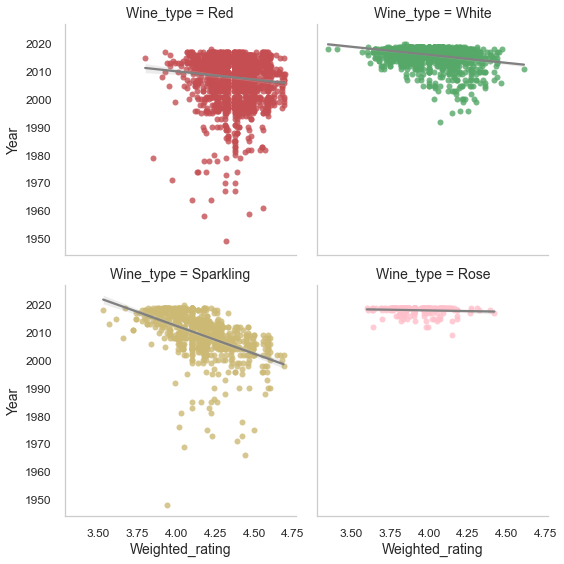

Red: -0.16161402213209808
White: -0.24429753605077253
Sparkling: -0.6040442285415724
Rose: -0.0746607446562948


In [62]:
# rating dependency on vintage for each type of wine
sns.lmplot(data=df, x='Weighted_rating', y='Year', col='Wine_type', hue='Wine_type',
           col_wrap=2, height=4, palette=dict(Red='r', White= 'g', Sparkling='y', Rose='pink'),
           line_kws={'color': 'grey'})

plt.show()

for wine_type in df['Wine_type'].unique():
    df_type = df[df['Wine_type']==wine_type]
    corr = spearmanr(df_type['Year'], df_type['Weighted_rating'], nan_policy='omit')[0]
    print(f"{wine_type}: {corr}")

Only for sparkling wines there is a negative correlation between vintage and rating: the older the wine, the higher its rating

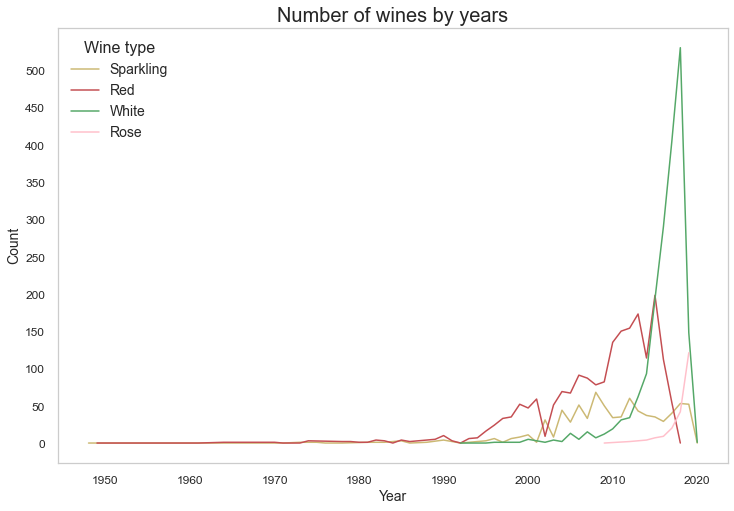

In [63]:
# a graph of the number of wines by year for each type of wine
count_by_years = df.groupby(['Year', 'Wine_type'], as_index=False)['Wine_id'].count()
sns.lineplot(data=count_by_years, x='Year', y='Wine_id', hue='Wine_type',
             palette=dict(Red='r', White= 'g', Sparkling='y', Rose='pink'))

plt.title('Number of wines by years')

plt.xlabel('Year')
plt.ylabel('Count')

plt.yticks(np.arange(0, max(count_by_years['Wine_id']), 50))

plt.legend(title='Wine type')

plt.show()

In [64]:
# number of wines produced by year intervals
df.groupby(df['Wine_type'])['Year'].value_counts(sort=False,bins=list(range(1940, 2021, 10)))

Wine_type  Year              
Red        (1939.999, 1950.0]       1
           (1950.0, 1960.0]         2
           (1960.0, 1970.0]         7
           (1970.0, 1980.0]        14
           (1980.0, 1990.0]        46
           (1990.0, 2000.0]       233
           (2000.0, 2010.0]       738
           (2010.0, 2020.0]       963
Rose       (1939.999, 1950.0]       0
           (1950.0, 1960.0]         0
           (1960.0, 1970.0]         0
           (1970.0, 1980.0]         0
           (1980.0, 1990.0]         0
           (1990.0, 2000.0]         0
           (2000.0, 2010.0]         1
           (2010.0, 2020.0]       212
Sparkling  (1939.999, 1950.0]       1
           (1950.0, 1960.0]         0
           (1960.0, 1970.0]         2
           (1970.0, 1980.0]         7
           (1980.0, 1990.0]        16
           (1990.0, 2000.0]        44
           (2000.0, 2010.0]       358
           (2010.0, 2020.0]       394
White      (1939.999, 1950.0]       0
           (1950.0, 

Sparkling and red wines have a large vintage range, while rosé and white wines are mostly young. Red and sparkling wines are best for long-term storage, while rosés do not store well. Most white wines have been produced in the last decade

In [65]:
# wines with a production region of more than 30 items
df_vintage = df[df.groupby('Region')['Region'].transform('size') > 30] 

# vintage chart: average rating of wines of different years for each region
df_vintage = df_vintage.pivot_table(index=['Country', 'Region'], columns=['Year'], values='Weighted_rating')
# sorted by descending year
df_vintage = df_vintage[df_vintage.columns[::-1]]

# find the best and worst wine vintages
df_vintage.style.highlight_max(color = 'green', axis = 1).highlight_min(color = 'red', axis = 1)

### Non-vintage wines research

In [66]:
print('– Number non-vintage wines in relation to total wines as a percentage: {:.1f}%'.format(len(df['Year'][df['Year'].isna()])/len(df['Year'])*100))
print(f"– Non-vintage wine type: {df['Wine_type'][df['Year'].isna()].unique()[0]}")
print(f"– The region that produces the most non-vintage wines: {df['Region'][df['Year'].isna()].mode().values[0]}")
print(f"– The top 3 non-vintage wines: {', '.join(map(str, df[df['Year'].isna()].nlargest(3, 'Weighted_rating')['Wine'].to_list()))}")

– Number non-vintage wines in relation to total wines as a percentage: 5.5%
– Non-vintage wine type: Sparkling
– The region that produces the most non-vintage wines: Champagne
– The top 3 non-vintage wines: Substance Blanc de Blancs Brut Champagne Grand Cru 'Avize', Lieux-dits La Cote Faron Extra Brut Champagne Grand Cru 'Aÿ', Grande Cuvée Brut Champagne


p < 0.05: True


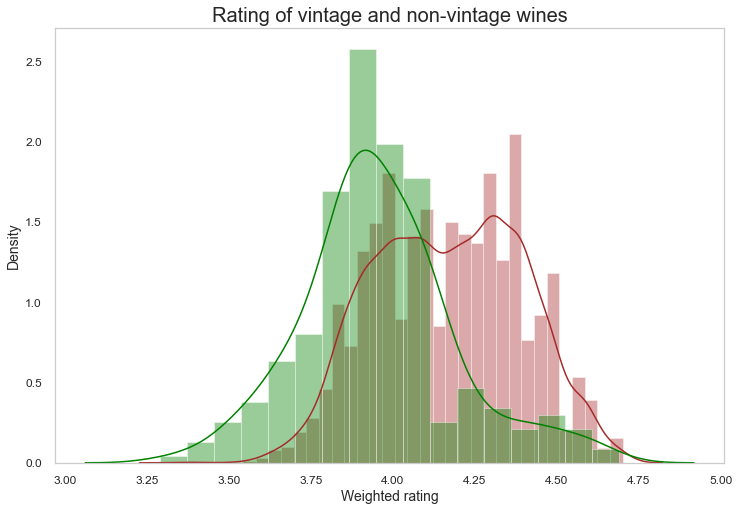

In [67]:
rating_vint = df[df['Year'].notna()]['Weighted_rating']
rating_non_vint = df[df['Year'].isna()]['Weighted_rating']

sns.distplot(rating_vint, color='brown')
sns.distplot(rating_non_vint, color='green')

plt.title('Rating of vintage and non-vintage wines')

plt.xlabel('Weighted rating')
plt.ylabel('Density')

# comparison of means using t-test
stat, p = ttest_ind(rating_vint, rating_non_vint, alternative='greater')
print(f'p < 0.05: {p < 0.05}')

Rating of non-vintage wines is lower than rating of vintage wines

### Price and rating research

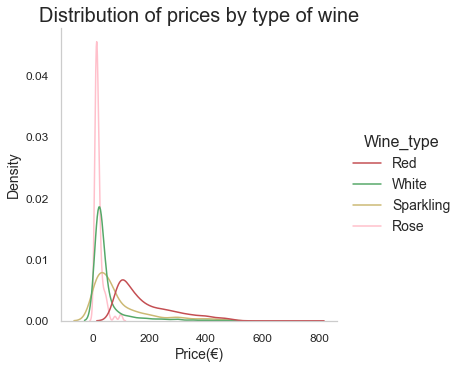

In [68]:
sns.displot(data=df, x='Price(€)', hue='Wine_type', common_norm=False, kind='kde',
            palette=dict(Red='r', White= 'g', Sparkling='y', Rose='pink'))

plt.title('Distribution of prices by type of wine')

plt.xlabel('Price(€)')
plt.ylabel('Density')


plt.show()

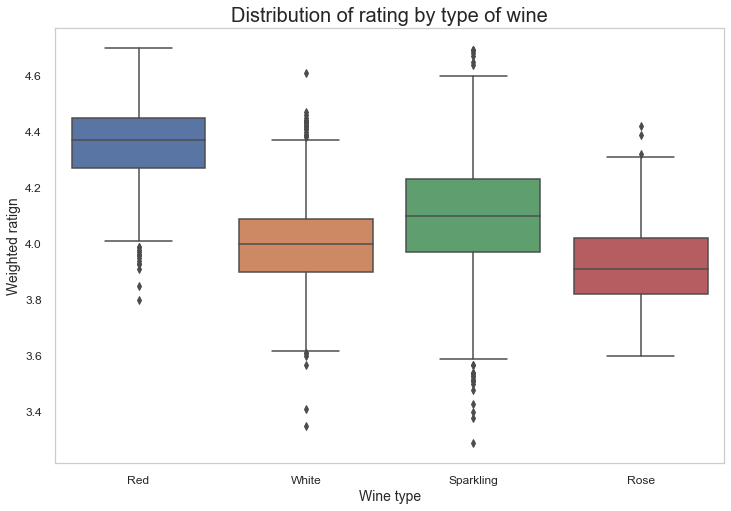

In [69]:
sns.boxplot(data=df, x='Wine_type', y='Weighted_rating')

plt.title('Distribution of rating by type of wine')

plt.xlabel('Wine type')
plt.ylabel('Weighted ratign')

plt.show()

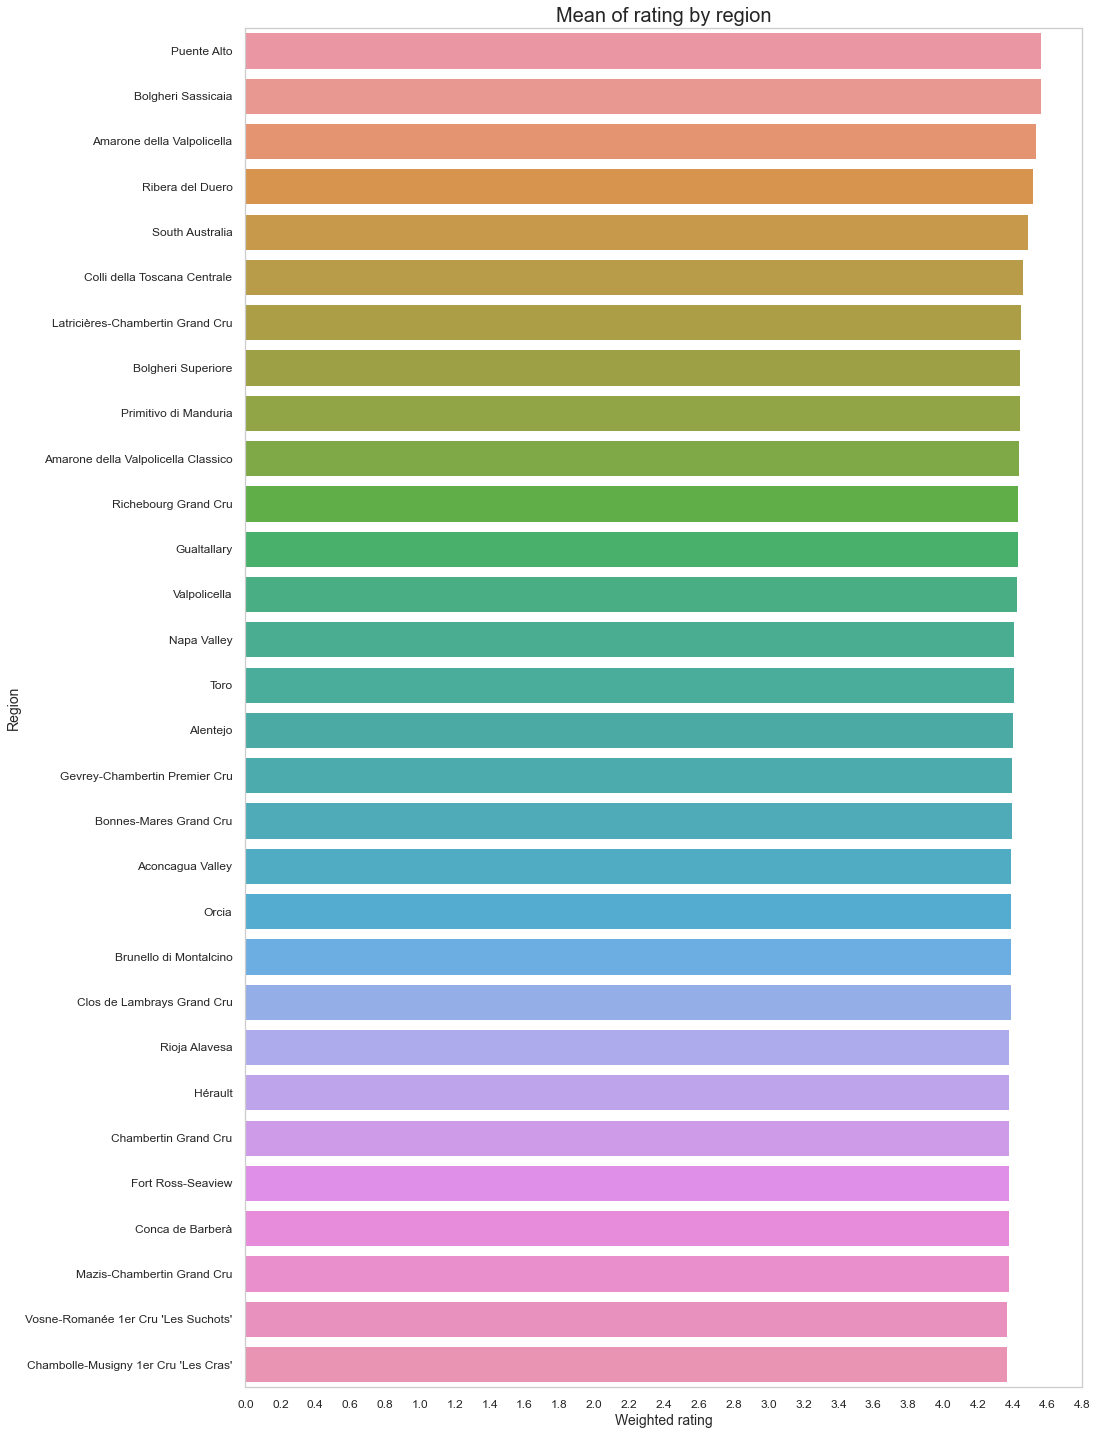

In [85]:
plt.figure(figsize=(15, 25))

df_reg_sort = df.groupby('Region', as_index=False)['Weighted_rating'].mean().sort_values('Weighted_rating', ascending=False)

sns.barplot(data=df_reg_sort[:30], x='Weighted_rating', y='Region', orient='h')

plt.title('Mean of rating by region')

plt.xlabel('Weighted rating')
plt.ylabel('Region')


plt.xticks(np.arange(0, 5, 0.2))

plt.show()

The price distribution is right-skewed, similar to a lognormal distribution. Price spikes are typical for most types of wines. Most rosés cost less than 100 euros. The price range for red wines is quite wide, the cost of a bottle of red wine is on average higher than that of others. Red wines are also generally rated higher than others. It is also noted that the distribution of ratings is different based on region

### Tastes and flavors research

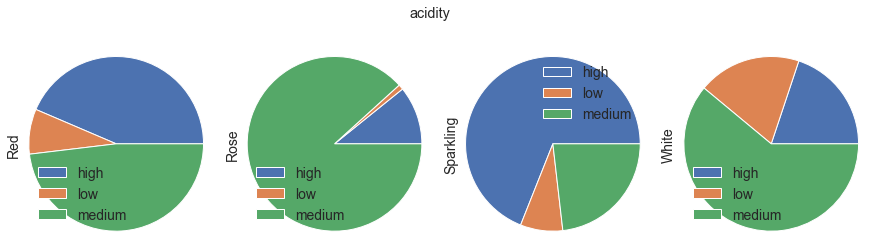

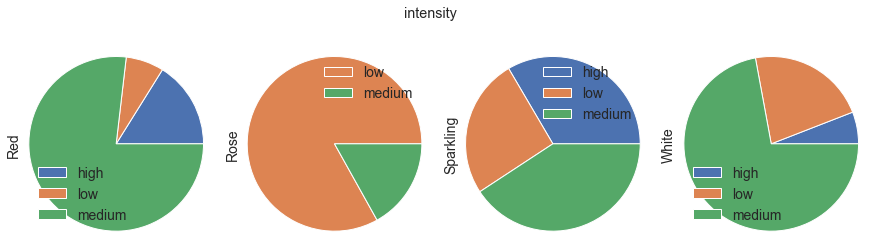

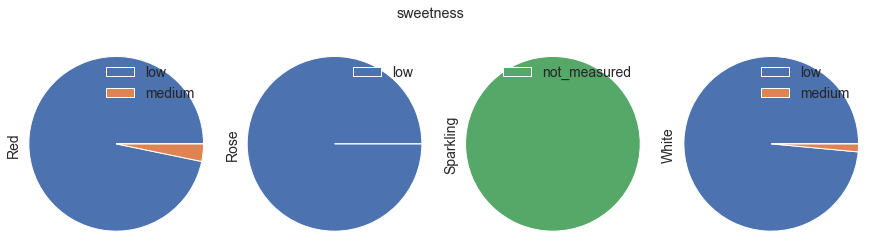

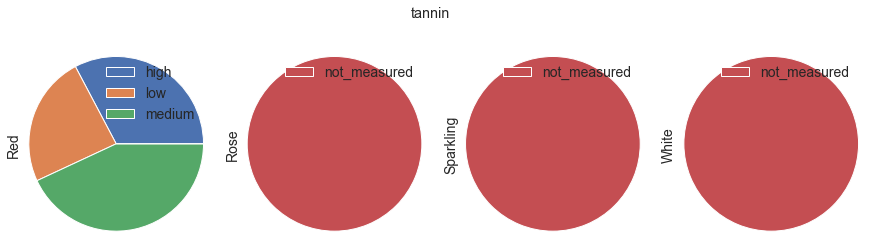

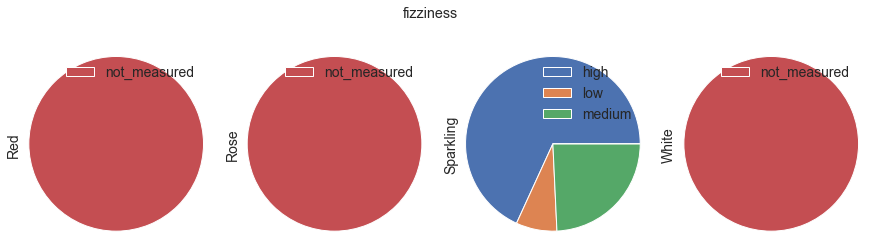

In [21]:
for taste in taste_cols:
    # taste distribution depending on the type of wine
    df_group = df.groupby(['Wine_type', taste])[taste].aggregate('count').unstack()

    df_group.T.plot.pie(subplots=True, layout=(1,4), figsize=(15, 4), 
                    labeldistance=None, title=taste, radius=1.2)
    

Red and sparkling wines have high acidity, while rose and white wines have medium acidity. Also full-bodied are red and sparkling wines. Rose wines are considered medium-bodied. Reds and rose are rated as "dry". Whites are often slightly sweeter than others. The tannin level is assessed only for red wines, and for sparkling wines - fizziness. Red wines have varying levels of tannin, and most sparkling wines are medium to high fizziness

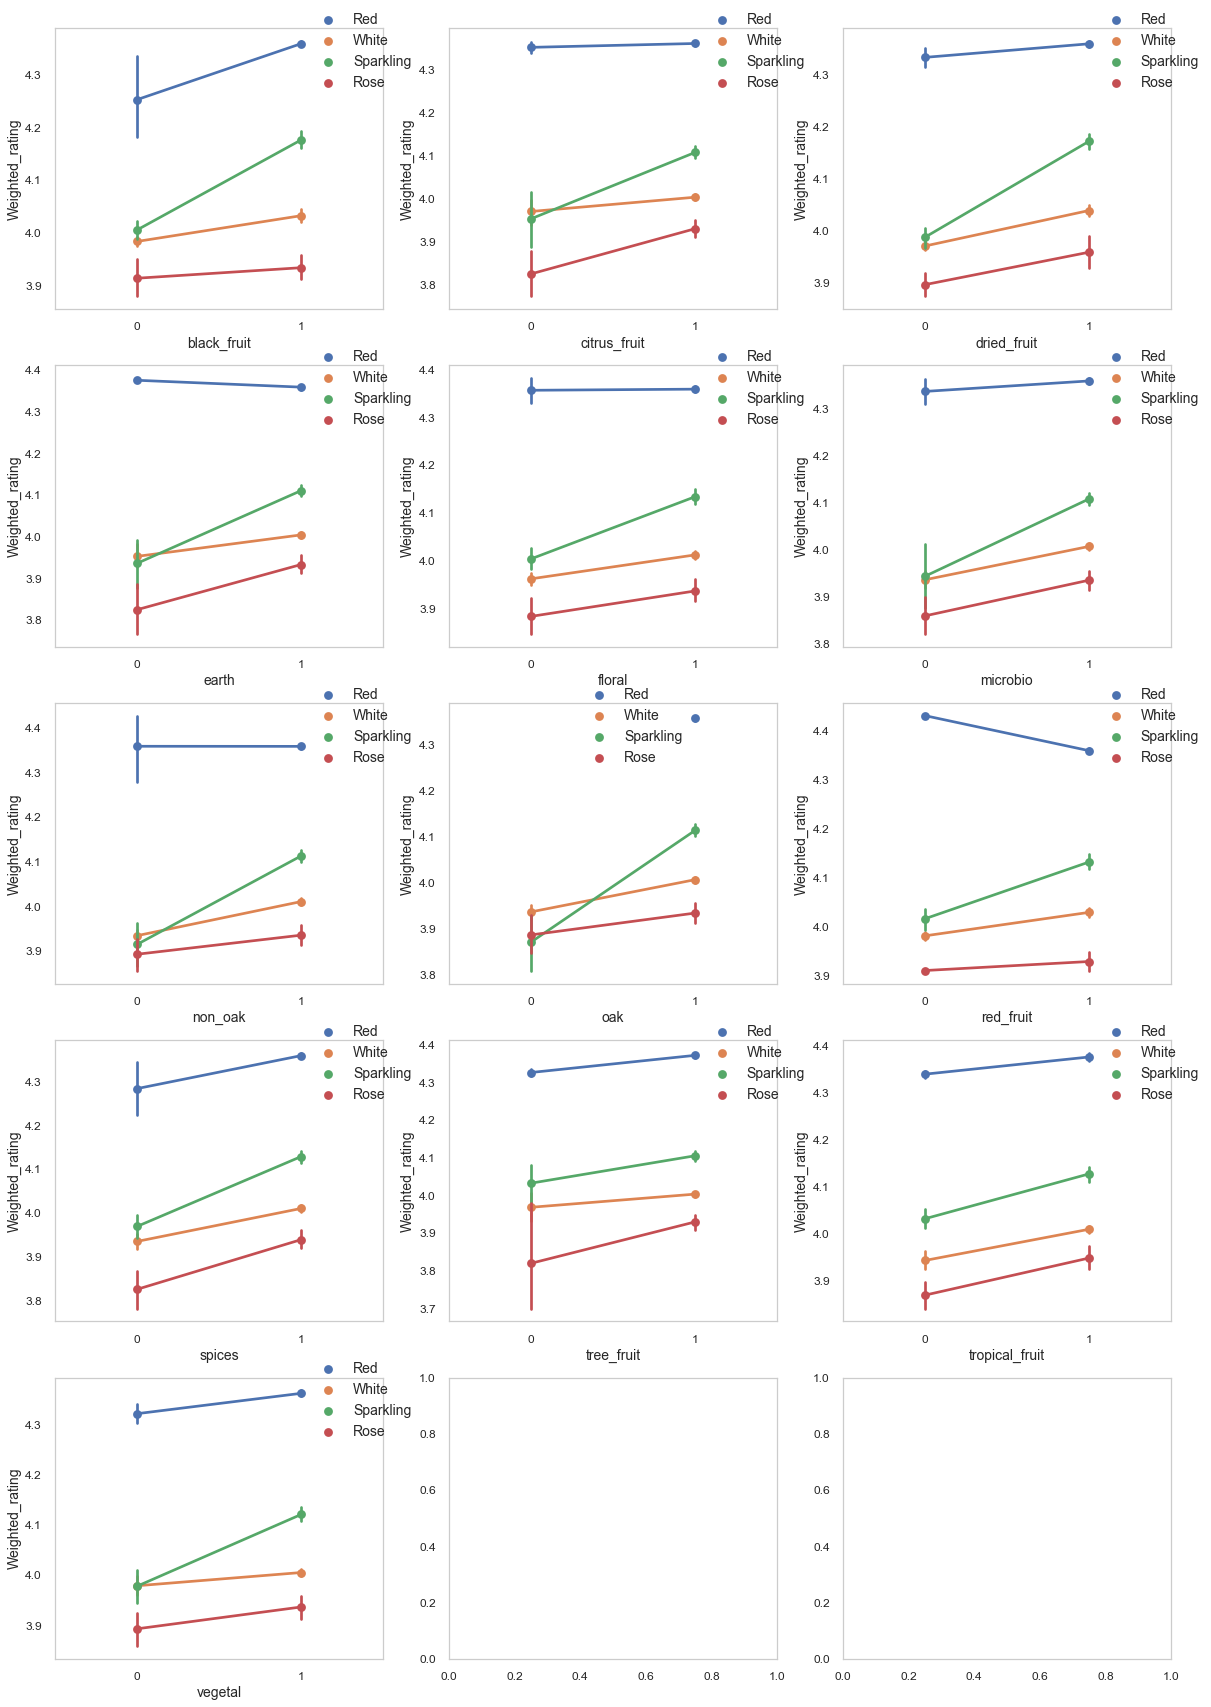

In [22]:
# flavor list
flavor_cols = df.loc[:, 'black_fruit':].columns

fig, axes = plt.subplots(5, 3, figsize=(20, 30))

for i, col in zip(axes.flatten(), flavor_cols):
    # estimate of central tendency of the rating for every flavor with confidence intervals
    sns.pointplot(data=df, x=col, y='Weighted_rating', hue='Wine_type', ax=i)
    
    i.legend(bbox_to_anchor=(0.75, 1.1))
    
    i.set_xlabel(col)
    i.set_ylabel('Weighted_rating')
    
    i.tick_params(labelsize=12)

The quality of sparkling wines depends on the presence of any flavors. Almost all notes have a positive effect on the rating of sparkling wine.
The presence of spicy notes has a positive effect on the assessment of all types of wines. The presence of a flavor of red fruit negatively affects the rating of red wines. According to users, tropical fruits are well suited for white wines

### Bottle research

In [23]:
# matching milliliters and type of bottles (unique column) and their number (count column)
df.groupby('Bottle_type_name')['Bottle_volume'].agg(['unique', 'count'])

unique  count
Bottle_type_name               
bottle             [750]   5072
magnum            [1500]    143
½ bottle           [375]      7

In [24]:
# number of different types of bottles for each type of wine
df.groupby(['Wine_type', 'Bottle_type_name'])['Bottle_type_name'].count().unstack()

Bottle_type_name  bottle  magnum  ½ bottle
Wine_type                                 
Red               1923.0    81.0       NaN
Rose               199.0    14.0       NaN
Sparkling         1076.0    32.0       1.0
White             1874.0    16.0       6.0

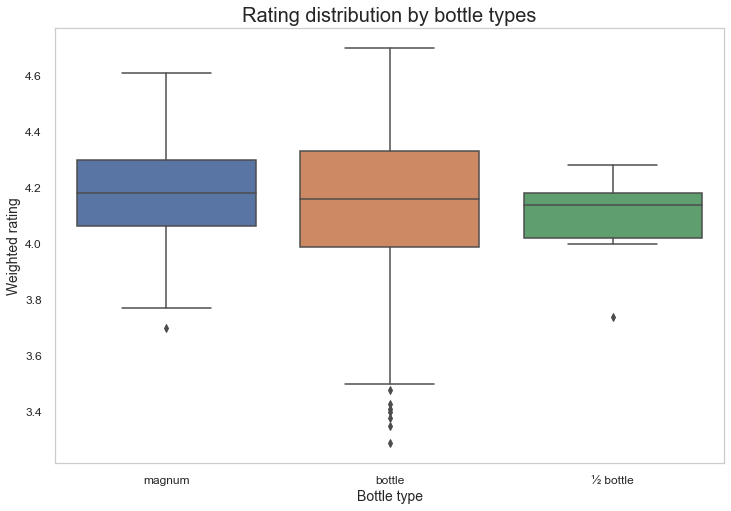

In [25]:
sns.boxplot(data=df, x='Bottle_type_name', y='Weighted_rating')

plt.title('Rating distribution by bottle types')

plt.xlabel('Bottle type')
plt.ylabel('Weighted rating')

plt.show()

In [26]:
# using F-Tests in One-Way ANOVA to compare means 
_, pvalue = f_oneway(df[df['Bottle_type_name']=='bottle']['Weighted_rating'],
                                df[df['Bottle_type_name']=='magnum']['Weighted_rating'],
                                df[df['Bottle_type_name']=='½ bottle']['Weighted_rating'])
print(f'p < 0.05: {pvalue < 0.05}') # not reject the null hypothesis

p < 0.05: False


In the wine market, most wines are presented in 750 ml bottles. Any wine is sold in a magnum, but most often red. In small bottles only sparkling and white are sold. Wine rating doesn't depend on container

### Outliers 

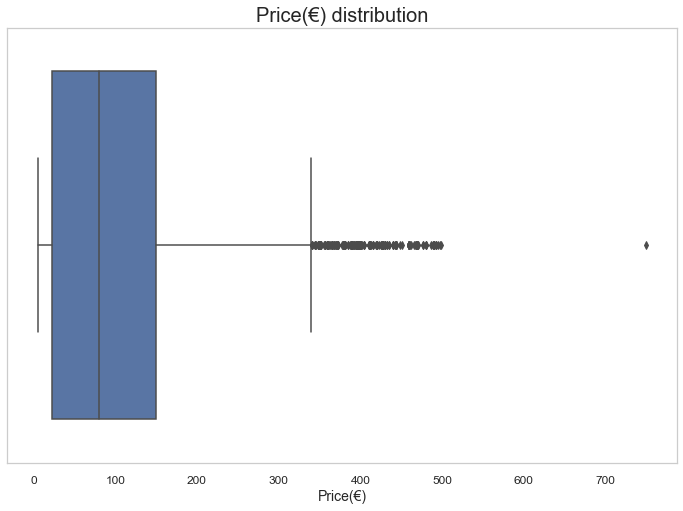

In [27]:
sns.boxplot(df['Price(€)'])

plt.title('Price(€) distribution')

plt.xlabel('Price(€)')

plt.show()

In [28]:
# detect and drop outlier using z-score
z = zscore(df['Price(€)'])
outlier = df[abs(z) > 3].index

print(f'{len(outlier) / len(df) * 100:.2f}% outliers')

df = df.drop(outlier).reset_index(drop=True) 

1.44% outliers


### Data Preparation

In [29]:
df.drop(['Wine_id', 'Wine', 'Bottle_quantity',
         'Bottle_type_id', 'Bottle_volume', 'Winery_id', 'Winery', 'Region_id',
        'Country', 'Regions_count', 'Users_count', 'Wineries_count', 'Wines_count',
         'Acidity', 'Body', 'Wine_style_description', 'Wine_region_name', 'Food'],
        axis=1, inplace=True)

In [30]:
# handling missing values
df[taste_cols] = df[taste_cols].fillna(0)
# only vintage wines
df = df.drop(df[df['Year'].isna()].index).reset_index(drop=True) 

Skew: 1.2393


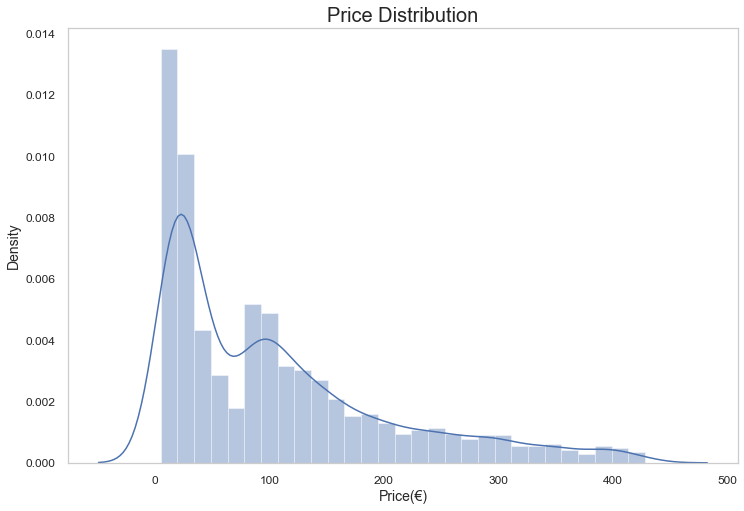

In [31]:
sns.distplot(df['Price(€)'])
print(f"Skew: {df['Price(€)'].skew():.4f}")

plt.title('Price Distribution')

plt.xlabel('Price(€)')
plt.ylabel('Density')

plt.show()

In [32]:
# Box-Cox transformation
df['Price(€)'] = boxcox(df['Price(€)'])[0]

In [33]:
# categorical data transformation
df = pd.get_dummies(df, columns=['acidity', 'intensity', 'sweetness', 'tannin', 'fizziness', 
                                 'Wine_type', 'Bottle_type_name'])

In [34]:
# getting grape varieties (no more than three in a blend)
df['Grapes'] = df['Grapes'].apply(lambda x: ast.literal_eval(x)[:3])

# for mca visualization
grapes = df['Grapes'].explode().apply(lambda x: f'Grapes_{x}')
# label encoding grape features
df = df.join(pd.crosstab(grapes.index, grapes))

df.drop('Grapes', axis=1, inplace=True)

In [35]:
#checking for interchangeability of wine style and grapes features

#filter by columns
subset=df[['Wine_style']].join(df.loc[:, 'Grapes_Aglianico':]) 

# filter by rows
# exclusion of unique wine styles
subset = subset[subset.groupby('Wine_style')['Wine_style'].transform('size') > 1]

# checking if all wines of the same style have the same grapes
print(f"Features are interchangeable: {all(subset.duplicated(keep=False).groupby(subset['Wine_style']).transform('all'))}")

df.drop('Wine_style', axis=1, inplace=True)

Features are interchangeable: True


In [36]:
# features used for MCA
mca_features = df.loc[:, 'Grapes_Aglianico':].columns.tolist()
mca_features.append('Region')

print(f'Number of features used for MCA: {len(mca_features)}')

Number of features used for MCA: 78


In [37]:
# dimensionality reduction with multiple correspondence analysis
mca = prince.MCA(n_components = 2, random_state=RANDOM_SEED)
mca = mca.fit(df[mca_features])

In [38]:
# dataframe with categorical features and mca copmonents
mca_df = mca.column_coordinates(df[mca_features]).reset_index().rename(
    columns={'index': 'cat_feature', 0: 'PC1', 1: 'PC2'})

# split into feature names and values
mca_df[['feature', 'value']] = mca_df['cat_feature'].str.split('_',  expand=True).values
mca_df.drop('cat_feature', axis=1, inplace=True)

# project categories onto mca copmonents
fig = px.scatter(mca_df, x='PC1', y='PC2', color='feature', hover_name='value',
                 hover_data=['PC1', 'PC2'], opacity=0.6, 
                 labels={'PC1': f'PC1 ({mca.explained_inertia_[0] * 100:.2f}% explaned inertia)',
                         'PC2': f'PC2 ({mca.explained_inertia_[1] * 100:.2f}% explaned inertia)'})

fig.update_traces(marker_size=15)

fig.update_layout(title = 'Row and column principal coordinates', title_x=0.5, autosize=True)


fig.show()

In [39]:
print(f'The percentage of explained inertia per principal component: {mca.explained_inertia_}')

The percentage of explained inertia per principal component: [0.1787596456041093, 0.17868852180739428]


In [40]:
# reduction of the number of features from 78 to 2
mca = mca.transform(df[mca_features])

# addition of principal components to the main dataframe
df = df.join(mca.rename(columns={0: 'PC1', 1: 'PC2'}))
df.drop(mca_features, axis=1, inplace=True)

In [41]:
# definition of numerical data
num_cols = ['Year', 'Weighted_rating', 'Price(€)']

# standardization of numerical data
col_trans = ColumnTransformer([('stand_num', StandardScaler(), num_cols)], remainder='passthrough')
df[num_cols] = col_trans.fit_transform(df[num_cols])

### Clustering

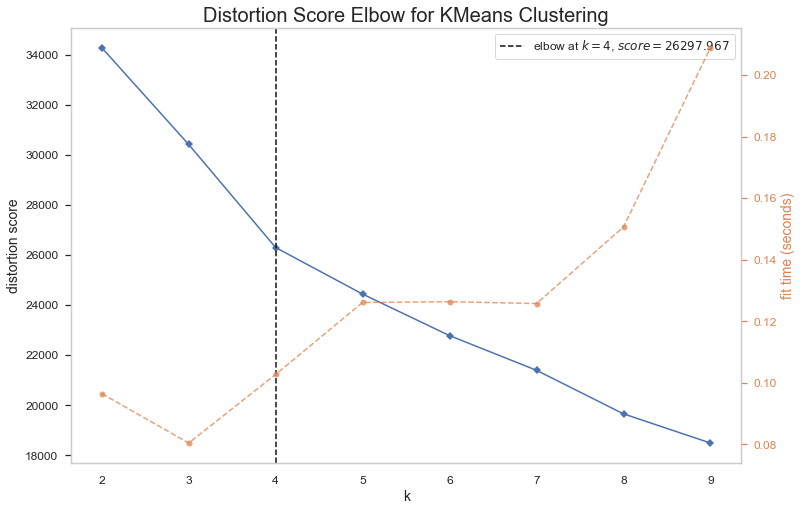

In [42]:
num_cols = df.iloc[:, 2:].columns
# K-Means clustering
model = KMeans(random_state=RANDOM_SEED)

# elbow method to select the optimal number of clusters by fitting the model with k from 2 to 10
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(df[num_cols])
visualizer.show()

plt.show()

In [43]:
# initialization and fitting K-means model with 4 clusters
model = KMeans(n_clusters=4, random_state=RANDOM_SEED).fit(df[num_cols]) 

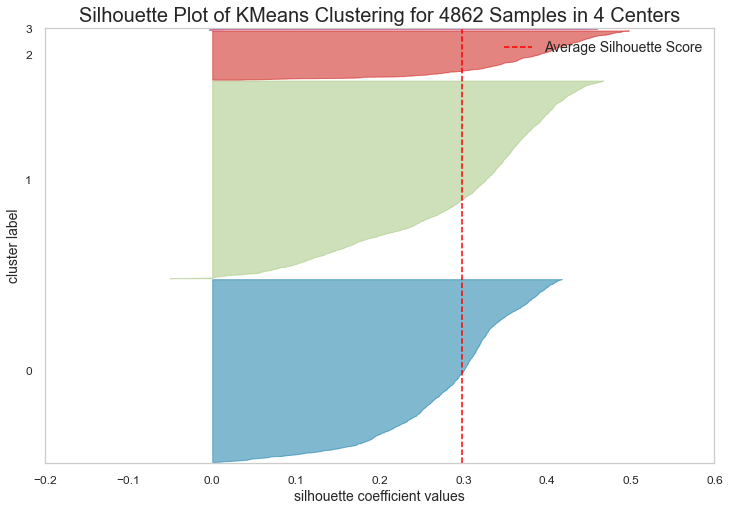

score: 0.30


In [44]:
# evaluating clusters with silhouette plot
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df[num_cols])
visualizer.show()

plt.show()

# calculating the silhouette score
print(f"score: {silhouette_score(df[num_cols], model.labels_, metric='euclidean'):.2f}")

In [45]:
# adding a column with cluster labels
df['Cluster'] = model.labels_ 
df['Cluster'] = df['Cluster'].astype(object)

# cluster sizes
print(df['Cluster'].value_counts())

1    2233
0    2065
2     556
3       8
Name: Cluster, dtype: int64


In [46]:
# dimensionality reduction using principal component analysis to visualize clusters
pca = PCA(n_components=2)
pca_clusters = pca.fit_transform(df[num_cols])

# adding information about the name of the wine and its cluster
pca_clusters = df[['Vintage_wine', 'Cluster']].join(pd.DataFrame(pca_clusters)).rename(columns={0: 'PC1', 1: 'PC2'})

fig = px.scatter(pca_clusters, x='PC1', y='PC2', hover_name='Vintage_wine', 
                 color='Cluster', hover_data=['PC1', 'PC2'])

fig.update_traces(marker_size=10)

fig.update_layout(title = 'Cluster visualization', title_x=0.5, autosize=True)

fig.show()

In [47]:
# categorical data transformation
df = pd.get_dummies(df, columns=['Cluster'])

### Wine Recommendation System

In [48]:
# wine user vector
def get_vector(df_user_wines):
    wine_vectors = []
    
    # wines highly rated by the user
    good_wines = df_user_wines[df_user_wines['rating'] >= 4.5]

    for user_wine in good_wines['wine_id']:
        # search for wine in the existing dataframe
        wine_match = df[df['Vintage_wine_id'] == user_wine]
        
        # ignoring wines without data
        if wine_match.empty:
            continue
        
        wine_values = wine_match[num_cols].values
        wine_vectors.append(wine_values)
    
    # a matrix with data on wines liked by the user
    wine_matrix = np.array(list(wine_vectors))
    
    return np.mean(wine_matrix, axis=0)



def get_recommendation(df_user_wines, n_wines=10, n_vintages=5):
    wine_user_vector = get_vector(df_user_wines)
    # removal from the dataframe of wines already rated by the user
    df_recom = df[~df['Vintage_wine_id'].isin(df_user['wine_id'])].reset_index(drop=True)
    
    # finding cosine distance between vectors
    distances = cdist(wine_user_vector, df_recom[num_cols], 'cosine') 
    
    # sorting by increasing cosine distance
    df_recom['cos_dist'] = distances[0]
    df_recom.sort_values('cos_dist', inplace=True)
    # splitting of wine and vintage name
    df_recom[['name', 'year']] = df_recom['Vintage_wine'].str.split(r' (?=\d{4}$)', expand=True).values

    # top unique wines by cosine distance
    rec_wines = df_recom['name'].unique()[:n_wines]
    # vintages of top unique wines
    rec_vintage_wines = df_recom[df_recom['name'].isin(rec_wines)].groupby('name')['year'].agg(['unique']).reset_index()
    # top vintages of top unique wines
    rec_vintage_wines['vintages'] = rec_vintage_wines['unique'].apply(lambda x: x[:n_vintages])
    
    return rec_vintage_wines[['name', 'vintages']].to_dict(orient='records') 

In [49]:
get_recommendation(df_user)

[{'name': 'Antinori Tenuta Guado al Tasso Bolgheri Superiore',
  'vintages': array(['2009', '2005', '2011', '2008', '2003'], dtype=object)},
 {'name': 'Biondi-Santi Brunello di Montalcino',
  'vintages': array(['2007', '2006', '2004', '2012', '2008'], dtype=object)},
 {'name': 'Casanova di Neri Tenuta Nuova Brunello di Montalcino',
  'vintages': array(['2010', '2007', '2015'], dtype=object)},
 {'name': 'Fontodi Flaccianello della Pieve',
  'vintages': array(['2006', '2016', '2015'], dtype=object)},
 {'name': 'Il Marroneto Madonna delle Grazie Brunello di Montalcino',
  'vintages': array(['2012', '2013', '2015', '2003'], dtype=object)},
 {'name': 'Le Macchiole Messorio',
  'vintages': array(['2009', '2006', '2010', '2011', '2001'], dtype=object)},
 {'name': 'Monteverro Toscana',
  'vintages': array(['2009', '2008', '2011', '2013', '2014'], dtype=object)},
 {'name': 'Petrolo Galatrona',
  'vintages': array(['2007', '2008', '2009', '2005', '2011'], dtype=object)},
 {'name': 'Salvioni Brun